In [114]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from scipy import stats
from copy import deepcopy
from scipy.special import softmax
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [115]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])
# series.diff().fillna(series).plot(figsize=(16, 7))

## Simple Moving Avarage

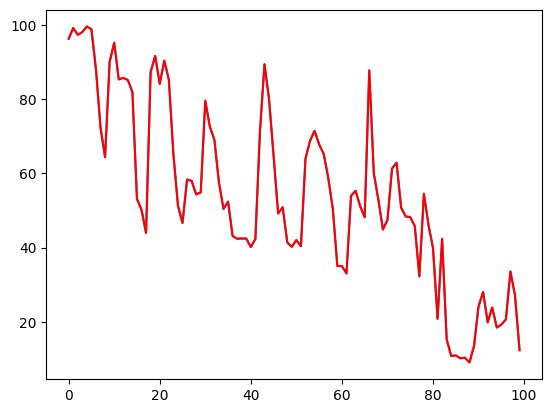

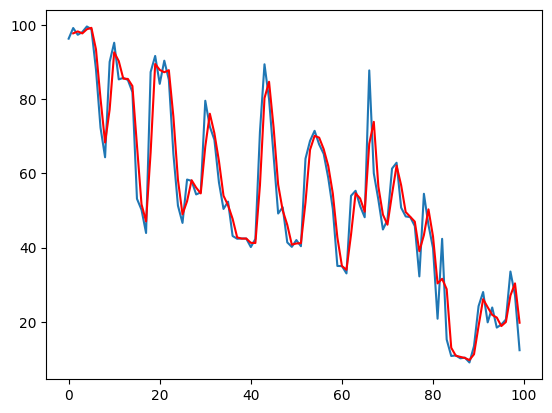

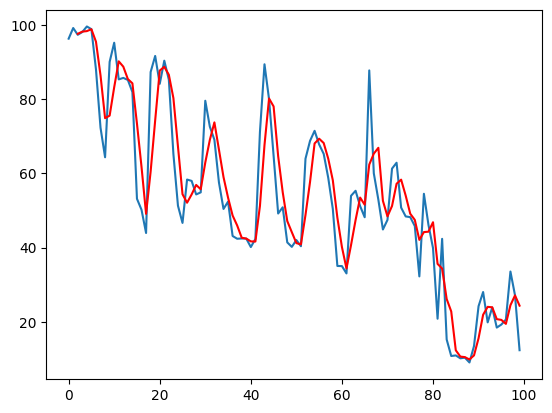

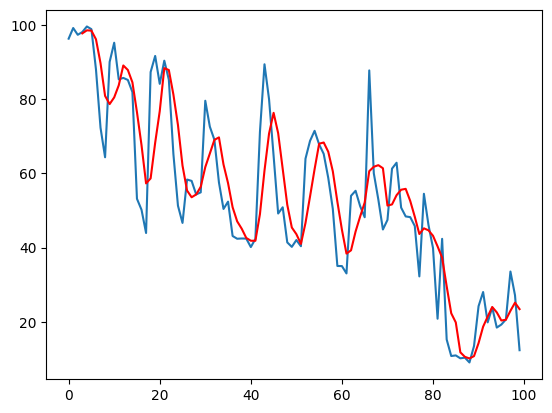

         Timestamp  OutboundUtilzation (%)  OutboundUtilzation (%)_1sma  \
0  10/10/2017 7:01                 96.2442                      96.2442   
1  10/10/2017 7:21                 99.1131                      99.1131   
2  10/10/2017 7:26                 97.2892                      97.2892   
3  10/10/2017 7:31                 98.0286                      98.0286   
4  10/10/2017 7:36                 99.5263                      99.5263   
5  10/10/2017 7:41                 98.8014                      98.8014   
6  10/10/2017 7:46                 87.9636                      87.9636   
7  10/10/2017 7:51                 72.2780                      72.2780   
8  10/10/2017 7:56                 64.3286                      64.3286   
9  10/10/2017 8:01                 89.9914                      89.9914   

   OutboundUtilzation (%)_2sma  OutboundUtilzation (%)_3sma  \
0                          NaN                          NaN   
1                     97.67865                  

In [116]:
# Tail-rolling average transform
network_analytics_copy = deepcopy(network_analytics)

for x in range(1, 5):
    rolling = series.rolling(window=x)
    rolling_mean = rolling.mean()
    network_analytics_copy = network_analytics_copy.join(rolling_mean, rsuffix=f"_{x}sma")
    # plot original and transformed dataset
    plt.plot(series[0:100])
    plt.plot(rolling_mean[0:100], color='red')
    plt.show()

print(network_analytics_copy.head(10))

In [117]:
df = pd.DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
print(dataframe.head(10))

        mean      t-1      t+1
0        NaN      NaN  96.2442
1        NaN  96.2442  99.1131
2        NaN  99.1131  97.2892
3        NaN  97.2892  98.0286
4  97.548833  98.0286  99.5263
5  98.143633  99.5263  98.8014
6  98.281367  98.8014  87.9636
7  98.785433  87.9636  72.2780
8  95.430433  72.2780  64.3286
9  86.347667  64.3286  89.9914


Test RMSE: 8.841, Window size: 1
Test RMSE: 10.020, Window size: 2
Test RMSE: 10.944, Window size: 3
Test RMSE: 11.719, Window size: 4
Test RMSE: 12.299, Window size: 5
Test RMSE: 12.707, Window size: 6
Test RMSE: 13.027, Window size: 7
Test RMSE: 13.258, Window size: 8
Test RMSE: 13.397, Window size: 9
Test RMSE: 13.489, Window size: 10
Test RMSE: 13.547, Window size: 11
Test RMSE: 13.588, Window size: 12
Test RMSE: 13.681, Window size: 13
Test RMSE: 13.816, Window size: 14
Test RMSE: 13.972, Window size: 15
Test RMSE: 14.139, Window size: 16
Test RMSE: 14.300, Window size: 17
Test RMSE: 14.446, Window size: 18
Test RMSE: 14.582, Window size: 19
Test RMSE: 14.695, Window size: 20


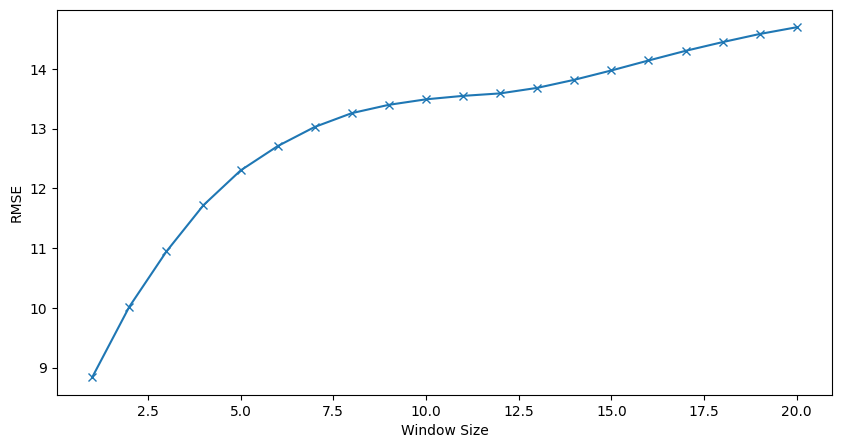

In [118]:
errors = []
range_size = range(1, 21)
for window in range_size:
    X = series.values
    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        # if t % 1000 == 0:
        #     print('predicted=%f, expected=%f' % (yhat, obs))
    error = sqrt(mean_squared_error(test, predictions))
    errors.append(error)
    print(f'Test RMSE: {error:.3f}, Window size: {window}')
    # plot
    # plt.figure(figsize=(15,7))
    # plt.plot(test)
    # plt.plot(predictions, color='red')
    # plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors, marker='x')


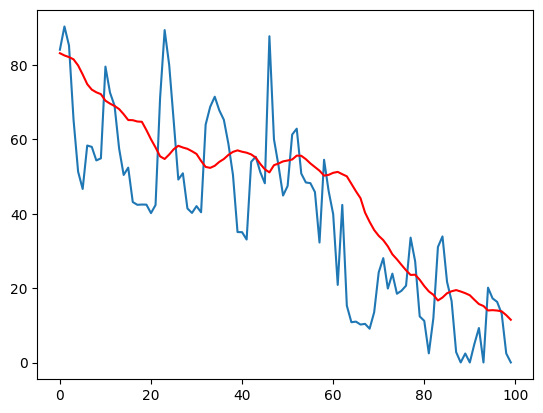

In [119]:
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

## Weighted Moving Average

In [120]:
def generate_random_weights(size : int) -> np.array :
    random_array = np.random.dirichlet(np.ones(size))
    while (np.sum(random_array) != 1.0):
        random_array = np.random.dirichlet(np.ones(size))
    return random_array

X = series.values

def optim_func(weights, X, window):
    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length-window,length)], weights=weights)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    error = sqrt(mean_squared_error(test, predictions))
    return error


def run_wma(window : int):
    res = minimize(optim_func, generate_random_weights(window), args=(X, window), method='SLSQP', bounds=[(0.0, 1.0)]*window, constraints=dict(type='ineq', fun=lambda X: 1.0 - X.sum()))
    weights = softmax(res.x)

    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length-window,length)], weights=weights)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        if t % 10000 == 0:
            print('predicted=%f, expected=%f' % (yhat, obs))
    error = sqrt(mean_squared_error(test, predictions))
    print(f"Test RMSE: {error:.3f}, Weights: {weights}, Weights sum: {np.sum(weights)}")

    plt.figure(figsize=(15,7))
    plt.plot(test[:500])
    plt.plot(predictions[:500], color='red')
    plt.show()
    return error


predicted=98.341534, expected=97.289200
predicted=72.897960, expected=58.201500
predicted=69.977535, expected=68.956300
Test RMSE: 9.234, Weights: [0.26894142 0.73105858], Weights sum: 1.0


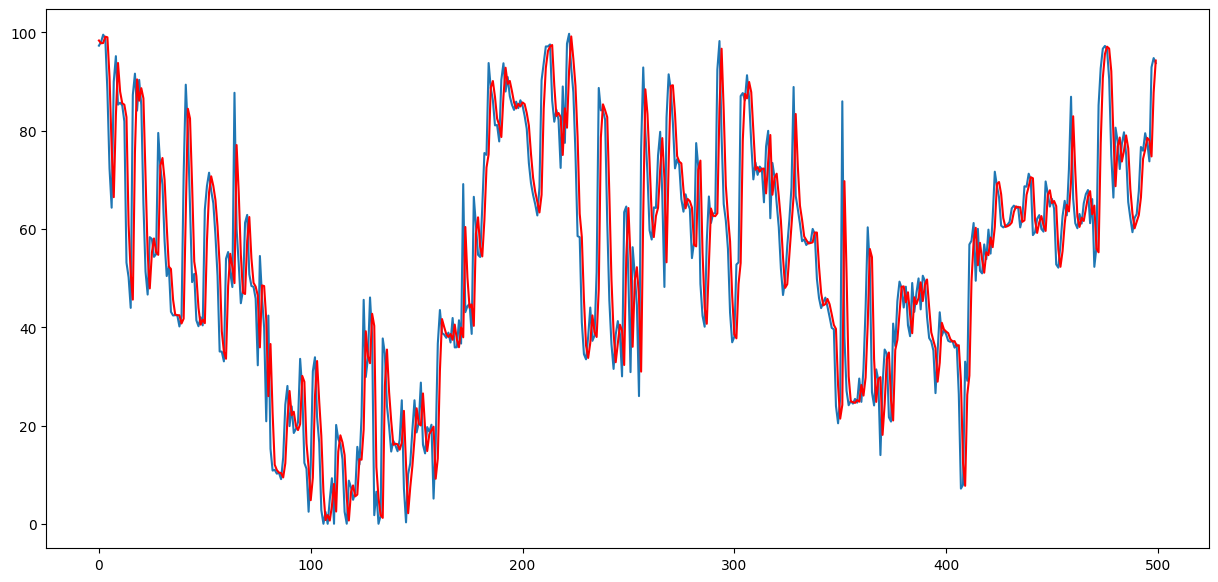

In [121]:
errors = []
errors.append(run_wma(2))

predicted=97.446621, expected=98.028600
predicted=65.522567, expected=52.722300
predicted=69.475445, expected=68.382100
Test RMSE: 9.784, Weights: [0.22507682 0.21526756 0.55965562], Weights sum: 1.0


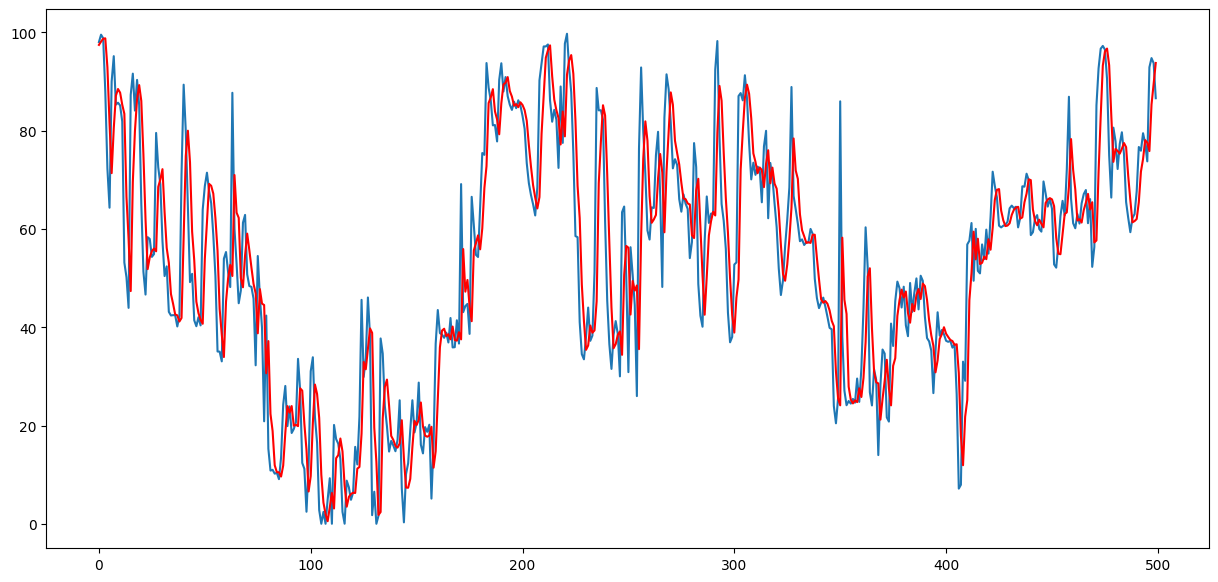

In [122]:
errors.append(run_wma(3))


predicted=97.756037, expected=99.526300
predicted=61.760110, expected=50.745000
predicted=69.123695, expected=67.578300
Test RMSE: 10.375, Weights: [0.18707919 0.17751836 0.17751836 0.4578841 ], Weights sum: 1.0


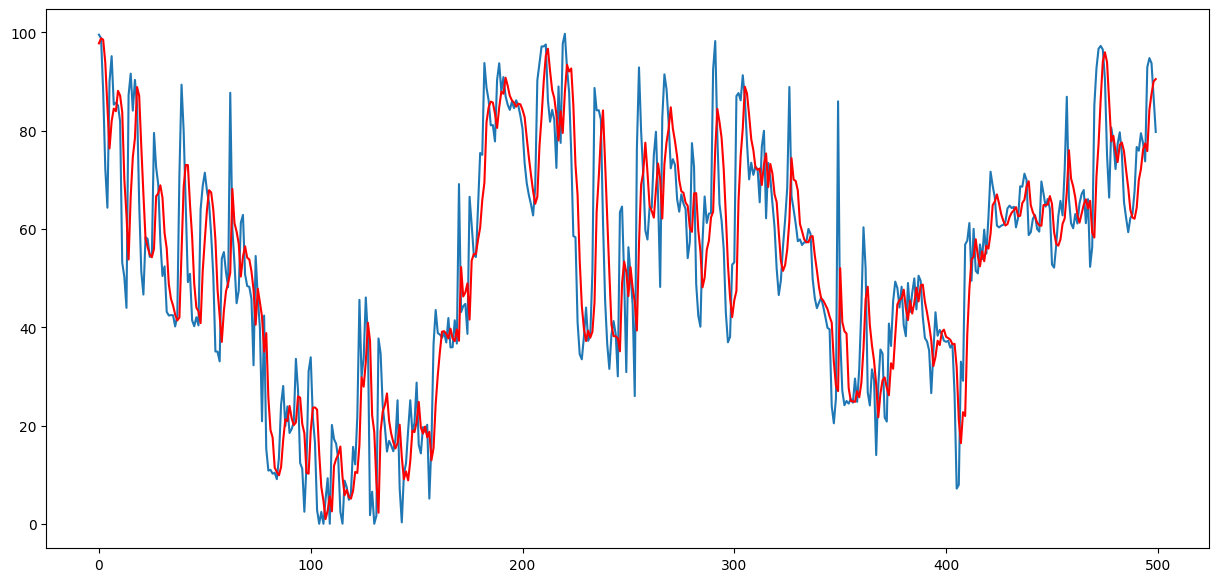

In [123]:
errors.append(run_wma(4))

predicted=98.362973, expected=98.801400
predicted=59.765520, expected=58.202600
predicted=68.714377, expected=63.696100
Test RMSE: 10.927, Weights: [0.16301497 0.1514696  0.1514696  0.1514696  0.38257622], Weights sum: 0.9999999999999999


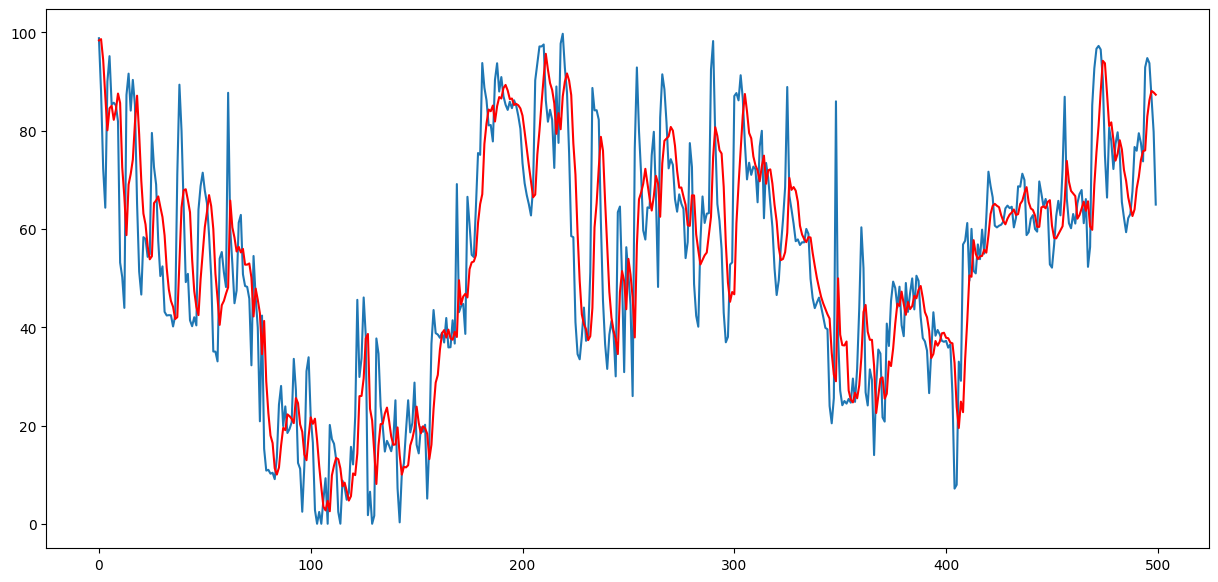

In [124]:
errors.append(run_wma(5))

predicted=98.267818, expected=87.963600
predicted=61.111521, expected=59.304000
predicted=67.300933, expected=61.482700
Test RMSE: 11.368, Weights: [0.1442498  0.13193399 0.13193399 0.13193399 0.13193399 0.32801422], Weights sum: 1.0


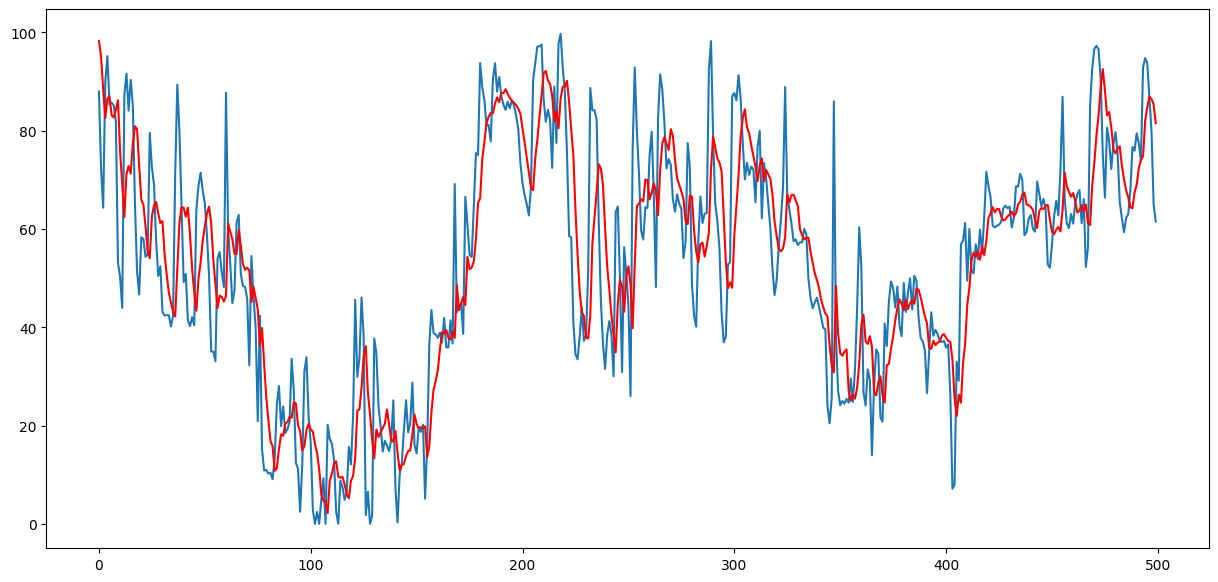

In [125]:
errors.append(run_wma(6))

predicted=95.213950, expected=72.278000
predicted=61.056496, expected=57.131800
predicted=66.243012, expected=65.826400
Test RMSE: 11.736, Weights: [0.12252595 0.12198422 0.11666835 0.11666835 0.11666835 0.11666835
 0.28881644], Weights sum: 1.0


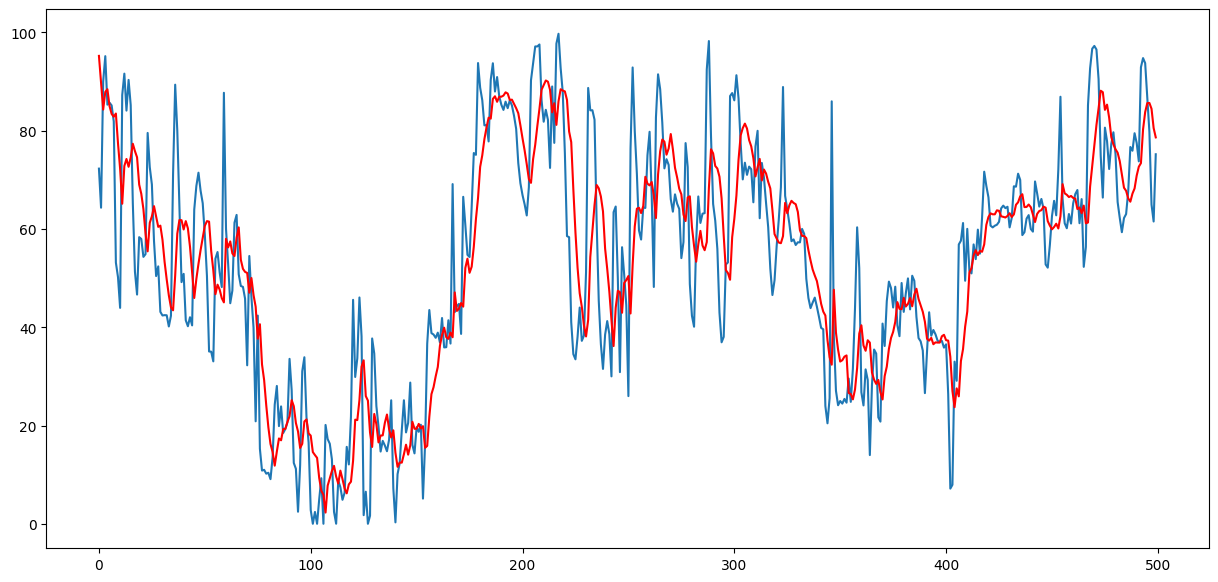

In [126]:
errors.append(run_wma(7))

predicted=90.444067, expected=64.328600
predicted=60.321066, expected=45.749700
predicted=66.874996, expected=60.537800
Test RMSE: 12.036, Weights: [0.11297507 0.10463133 0.10751035 0.10463133 0.10463133 0.10463133
 0.10463133 0.25635795], Weights sum: 0.9999999999999999


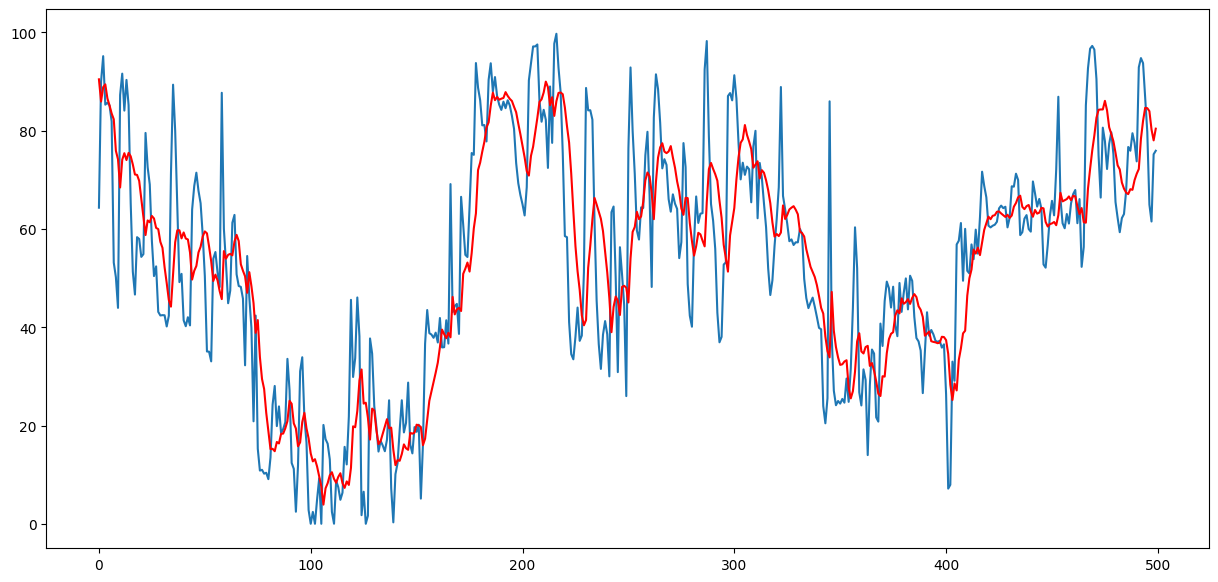

In [127]:
errors.append(run_wma(8))

predicted=86.952844, expected=89.991400
predicted=57.439620, expected=48.423400
predicted=65.568156, expected=55.383200
Test RMSE: 12.253, Weights: [0.10436757 0.09485973 0.09485973 0.09679513 0.09485973 0.09485973
 0.09485973 0.09485973 0.2296789 ], Weights sum: 1.0


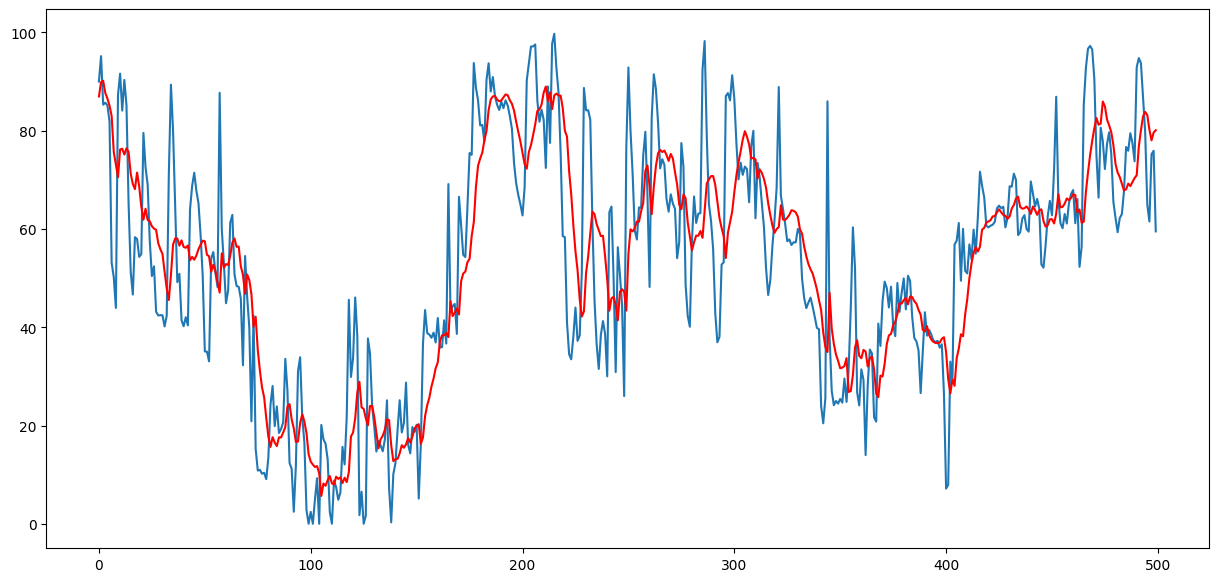

In [128]:
errors.append(run_wma(9))

predicted=90.394091, expected=95.157300
predicted=56.963732, expected=46.866500
predicted=64.058801, expected=52.258900
Test RMSE: 12.419, Weights: [0.09120419 0.09116048 0.0867176  0.0867176  0.08855887 0.0867176
 0.0867176  0.0867176  0.0867176  0.20877089], Weights sum: 1.0000000000000002


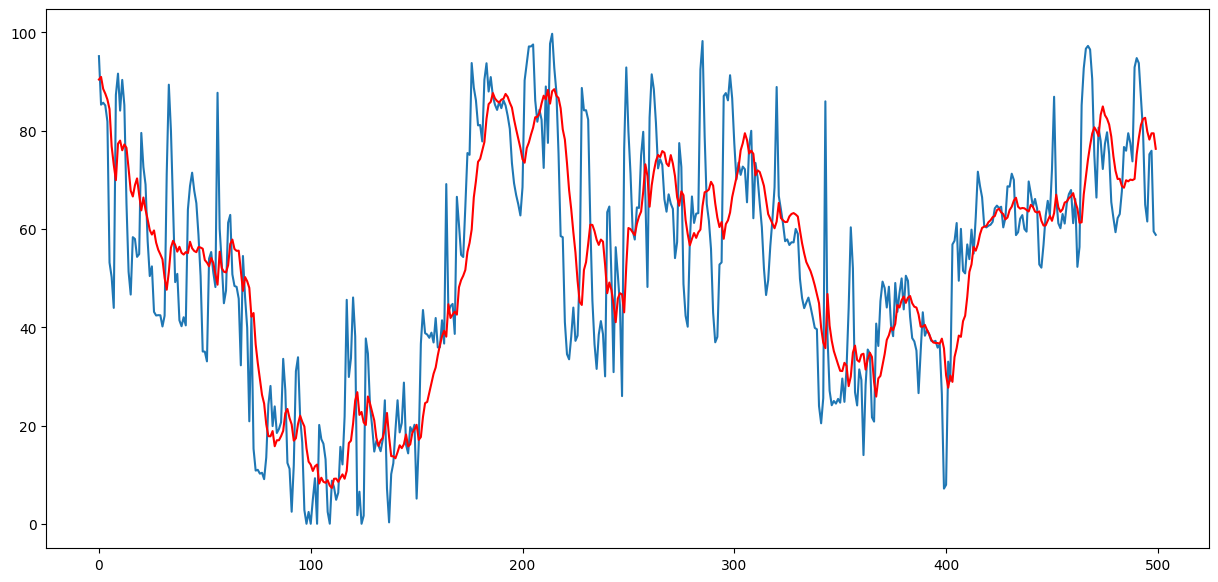

In [129]:
errors.append(run_wma(10))

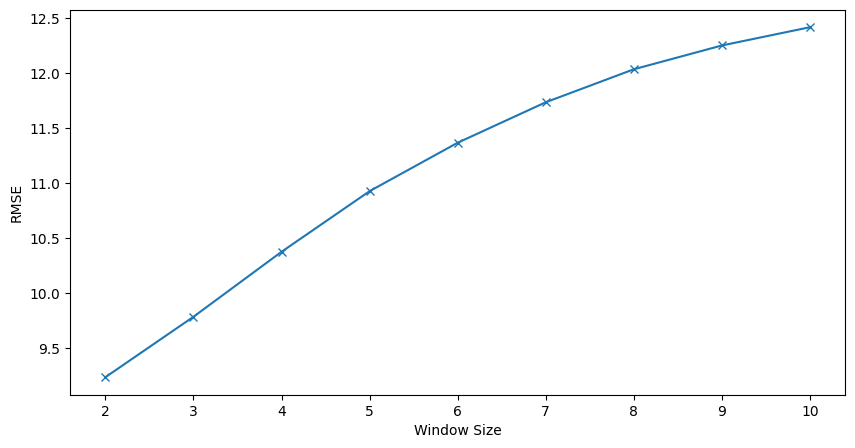

In [130]:
range_size = range(2, 11)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors, marker='x')

## Exponential Moving Average

In [131]:
def compute_ema(window : int):
    ema = series.ewm(span=window, adjust=False).mean()
    error = sqrt(mean_squared_error(X, ema))
    print(f"Test RMSE: {error:.3f}")
    plt.figure(figsize=(15,7))
    plt.plot(X[:500])
    plt.plot(ema[:500], color='red')
    plt.show()
    return error    

Test RMSE: 3.105


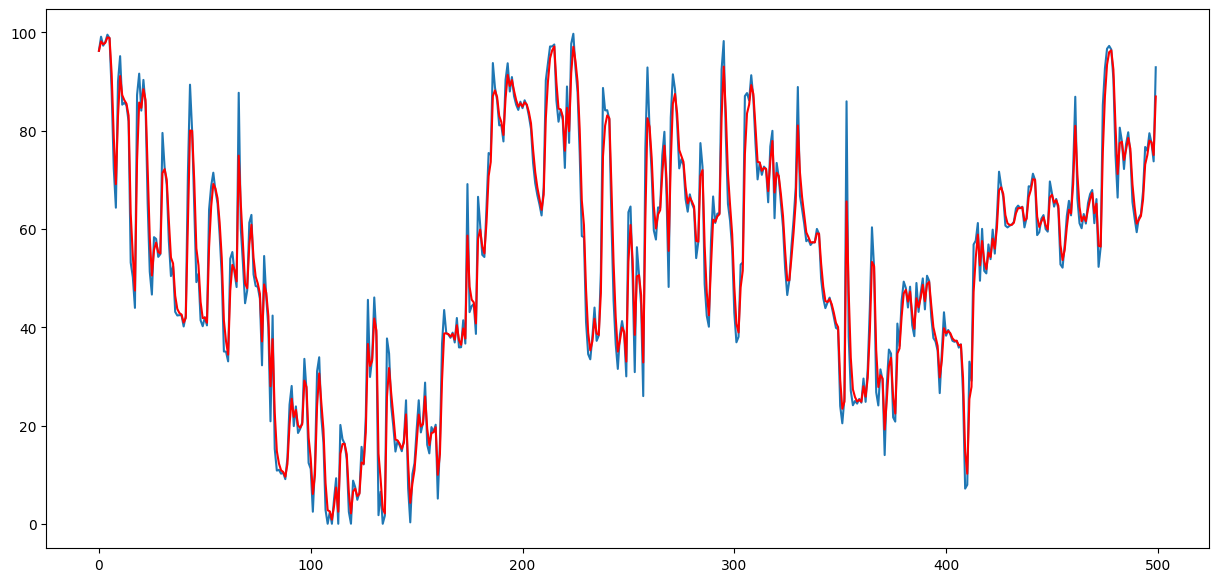

In [132]:
errors = []
errors.append(compute_ema(2))

Test RMSE: 4.934


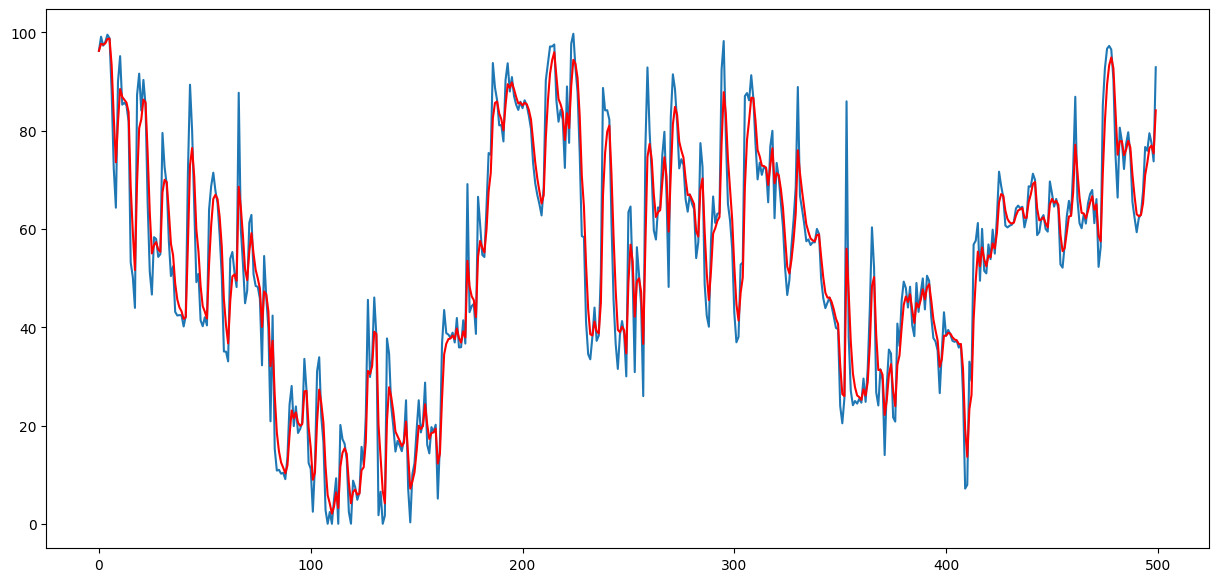

In [133]:
errors.append(compute_ema(3))

Test RMSE: 6.198


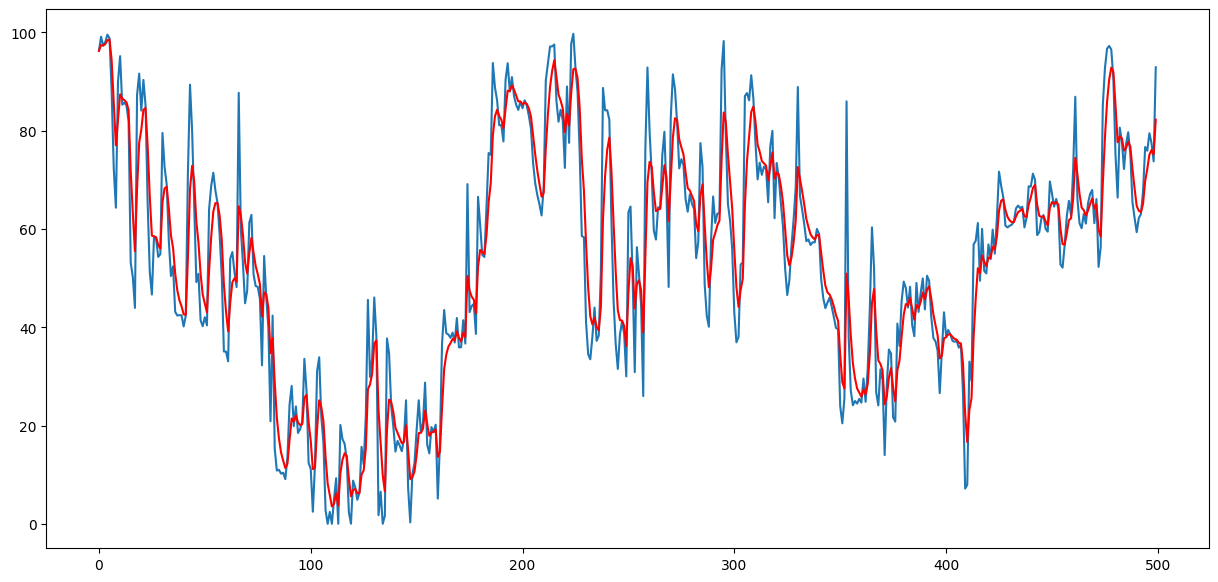

In [134]:
errors.append(compute_ema(4))

Test RMSE: 7.138


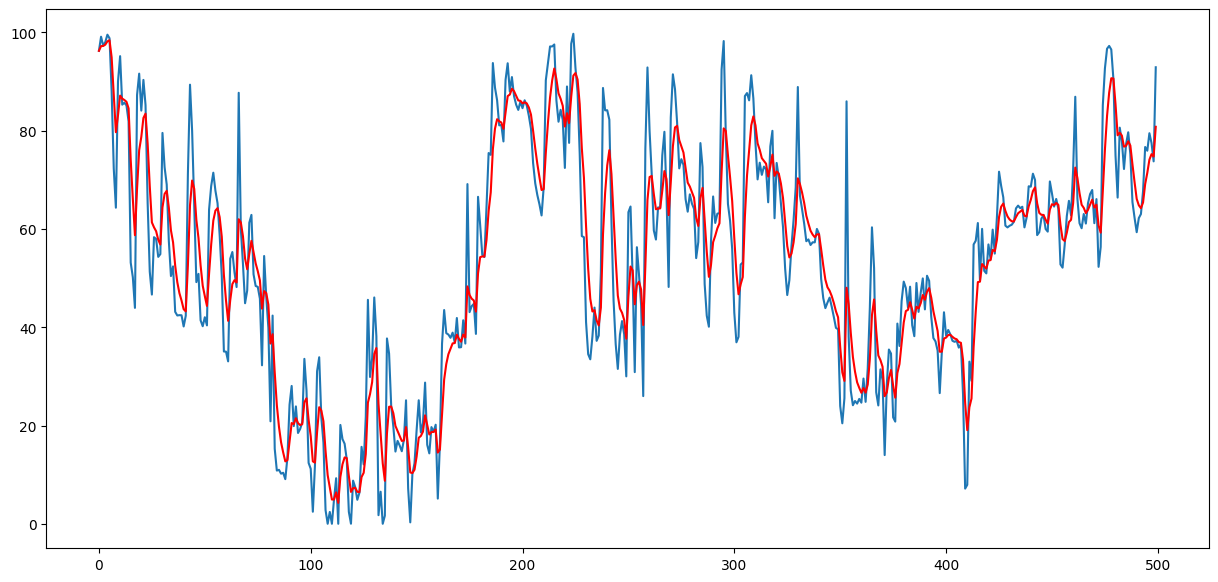

In [135]:
errors.append(compute_ema(5))

Test RMSE: 7.874


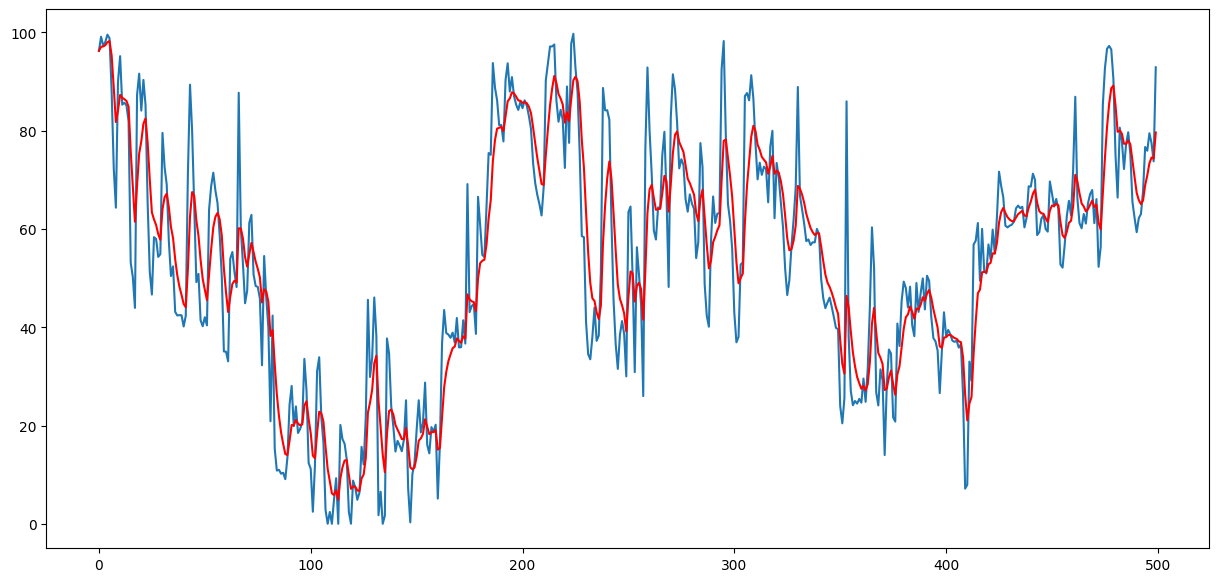

In [136]:
errors.append(compute_ema(6))

Test RMSE: 8.470


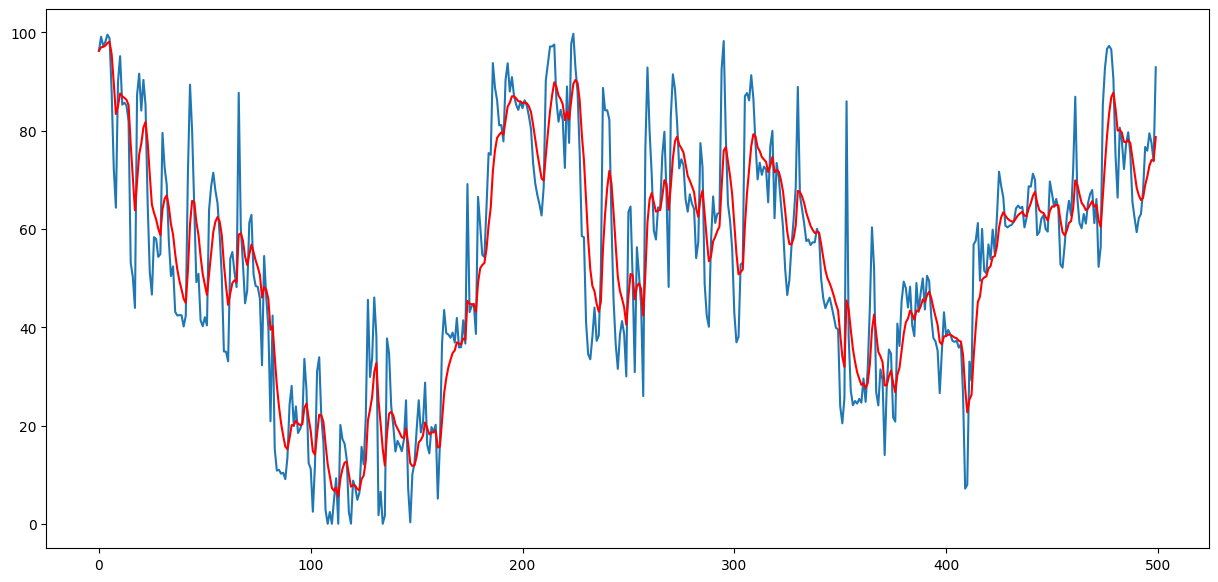

In [137]:
errors.append(compute_ema(7))

Test RMSE: 8.967


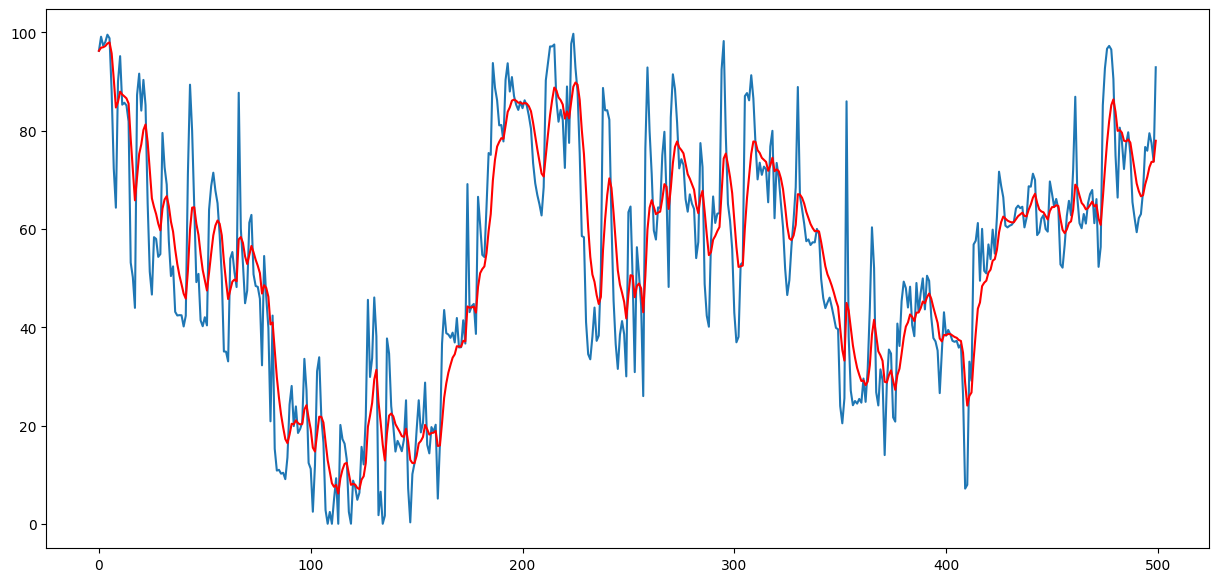

In [138]:
errors.append(compute_ema(8))

Test RMSE: 9.392


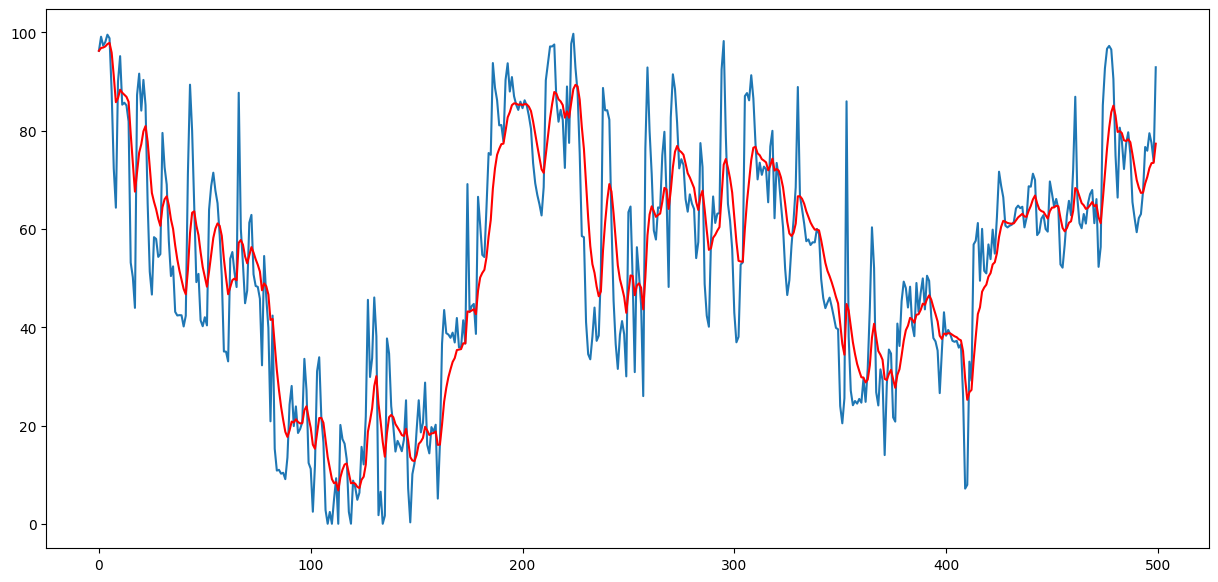

In [139]:
errors.append(compute_ema(9))

Test RMSE: 9.761


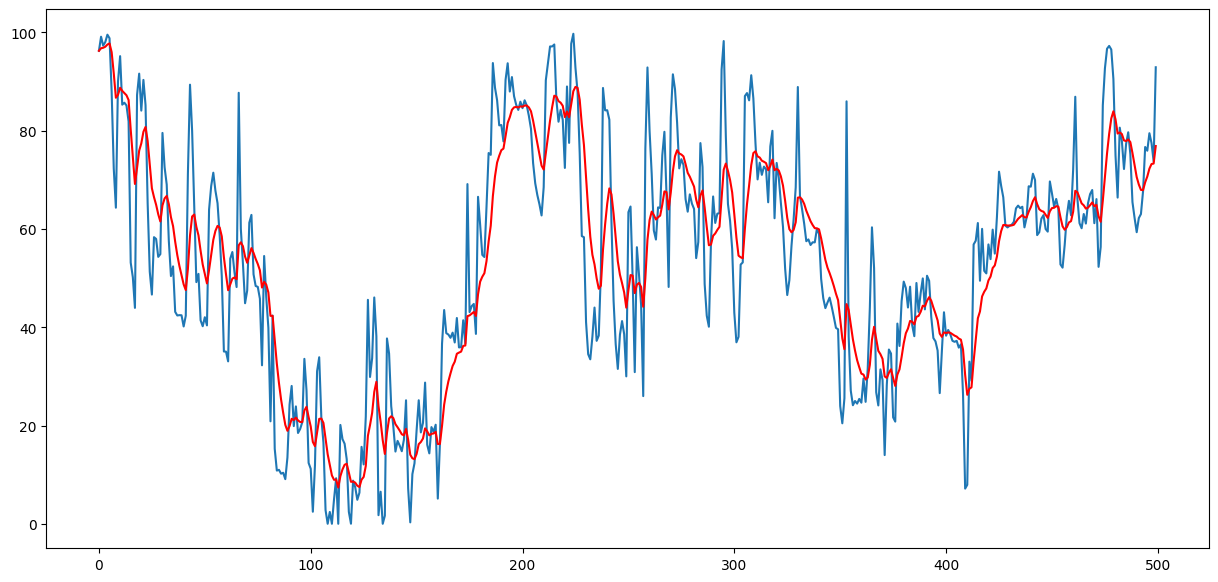

In [140]:
errors.append(compute_ema(10))

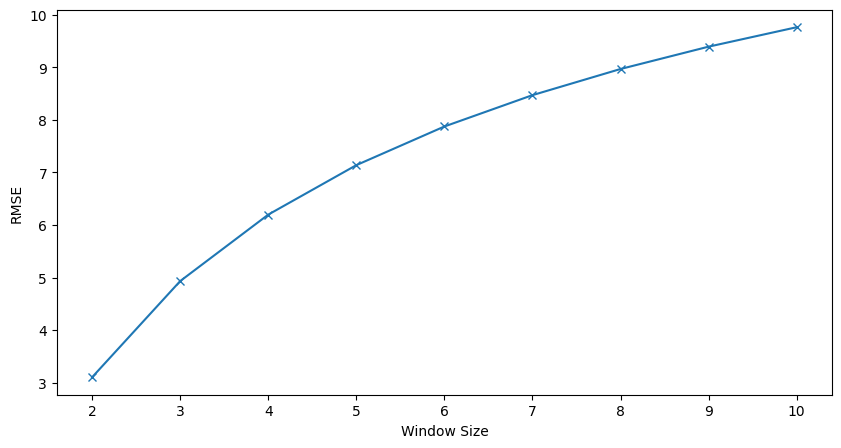

In [142]:
range_size = range(2, 11)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors, marker='x')